# Detecting COVID-19 in X-ray Images using VGG16 CNN Model

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

%matplotlib inline

In [2]:
#initialize the initial learning rate, number of epochs to train for and batch size
INIT_LR = 1e-3
EPOCHS = 25
BS = 8


In [5]:
# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("Loading images...")
imagePaths = list(paths.list_images(r"E:\AAIC\Case Studies\keras-covid-19\dataset"))
data = []
labels = []

# loop over the image paths
for imagePath in imagePaths:
    # extract the class label from the filename
    label = imagePath.split(os.path.sep)[-2]

    # load the image, swap color channels, and resize it to be a fixed
    # 224x224 pixels while ignoring aspect ratio
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))

    # update the data and labels lists, respectively
    data.append(image)
    labels.append(label)



Loading images...


In [10]:
# convert the data and labels to NumPy arrays while scaling the pixel
# intensities to the range [0, 255]
data = np.array(data) / 255.0
labels = np.array(labels)

In [11]:
data

array([[[[0.17254902, 0.16470588, 0.16862745],
         [0.20784314, 0.2       , 0.20392157],
         [0.22352941, 0.21568627, 0.21960784],
         ...,
         [0.36078431, 0.36078431, 0.36078431],
         [0.28235294, 0.28235294, 0.28235294],
         [0.21176471, 0.20392157, 0.21568627]],

        [[0.21176471, 0.20392157, 0.20784314],
         [0.21960784, 0.21176471, 0.21568627],
         [0.23137255, 0.22352941, 0.23137255],
         ...,
         [0.25882353, 0.25098039, 0.2627451 ],
         [0.27843137, 0.2745098 , 0.28235294],
         [0.27843137, 0.28235294, 0.29019608]],

        [[0.21176471, 0.20392157, 0.21568627],
         [0.22352941, 0.22352941, 0.23137255],
         [0.23529412, 0.23529412, 0.23529412],
         ...,
         [0.35686275, 0.35686275, 0.36470588],
         [0.24313725, 0.24313725, 0.25098039],
         [0.18431373, 0.17647059, 0.18823529]],

        ...,

        [[0.2745098 , 0.2745098 , 0.28235294],
         [0.29411765, 0.29411765, 0.30196078]

In [12]:
np.unique(labels)

array(['covid', 'normal'], dtype='<U6')

In [13]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [14]:
np.unique(labels)

array([0., 1.], dtype=float32)

In [15]:
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,test_size=0.20, stratify=labels, random_state=42)


In [16]:
# initialize the training data augmentation object
trainAug = ImageDataGenerator(rotation_range=15,fill_mode="nearest")


In [17]:
# load the VGG16 network, ensuring the head FC layer sets are left off
baseModel = VGG16(weights="imagenet", include_top=False,input_tensor=Input(shape=(224, 224, 3)))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
58892288/58889256 [==============================] - 51s 1us/step


In [18]:
# construct the head of the model that will be placed on top of the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)


In [19]:
# place the head FC model on top of the base model (this will become the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

In [20]:
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
    layer.trainable = False


In [21]:
# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])


[INFO] compiling model...


In [22]:
# train the head of the network
print("[INFO] training head...")
H = model.fit_generator(trainAug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)


[INFO] training head...
Epoch 1/25
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
5/5 [==============================] - 21s 4s/step - loss: 0.8538 - acc: 0.4500 - val_loss: 0.6208 - val_acc: 0.7000
Epoch 2/25
5/5 [==============================] - 17s 3s/step - loss: 0.7020 - acc: 0.5750 - val_loss: 0.6476 - val_acc: 0.5000
Epoch 3/25
5/5 [==============================] - 17s 3s/step - loss: 0.7348 - acc: 0.5000 - val_loss: 0.5904 - val_acc: 0.8000
Epoch 4/25
5/5 [==============================] - 17s 3s/step - loss: 0.7000 - acc: 0.6000 - val_loss: 0.5649 - val_acc: 1.0000
Epoch 5/25
5/5 [==============================] - 17s 3s/step - loss: 0.5823 - acc: 0.7000 - val_loss: 0.5545 - val_acc: 1.0000
Epoch 6/25
5/5 [==============================] - 17s 3s/step - loss: 0.7666 - acc: 0.5250 - val_loss: 0.5381 - val_acc: 1.0000
Epoch 7/25
5/5 [==============================] - 17s 3s/step - loss: 0.6015 - acc: 0.6000 - val_loss: 0.5273 - va

In [23]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

[INFO] evaluating network...


In [24]:
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

In [31]:
predIdxs

array([1, 1, 1, 1, 0, 0, 0, 0, 1, 0], dtype=int64)

In [33]:
testY.argmax(axis=1)

array([1, 1, 1, 1, 0, 0, 0, 0, 1, 0], dtype=int64)

In [25]:
# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,target_names=lb.classes_))

              precision    recall  f1-score   support

       covid       1.00      1.00      1.00         5
      normal       1.00      1.00      1.00         5

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10



In [26]:
# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
cm = confusion_matrix(testY.argmax(axis=1), predIdxs)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

In [27]:
# show the confusion matrix, accuracy, sensitivity, and specificity
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

[[5 0]
 [0 5]]
acc: 1.0000
sensitivity: 1.0000
specificity: 1.0000


In [59]:
def plot_Confusion_Matrix(actual_labels,predict_labels,title):
    """This function plot the confusion matrix"""
    # Reference : https://seaborn.pydata.org/generated/seaborn.heatmap.html
    cm = confusion_matrix(actual_labels, predict_labels)
    classNames = ['NO','YES']
    cm_data = pd.DataFrame(cm,index = classNames,
                  columns = classNames)
    plt.figure(figsize = (5,4))
    sns.heatmap(cm_data, annot=True,fmt="d")
    plt.title(title)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()


C:\Users\sanjeev\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


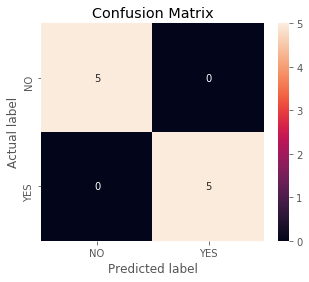

In [62]:
import pandas as pd
import seaborn as sns

plot_Confusion_Matrix(testY.argmax(axis=1), predIdxs,"Confusion Matrix")

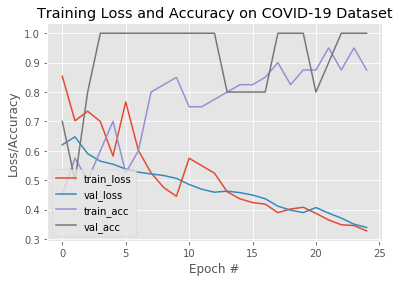

In [56]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

In [58]:
plt.savefig('plot.jpeg')

<Figure size 432x288 with 0 Axes>

In [34]:
# serialize the model to disk
print("[INFO] saving COVID-19 detector model...")
model.save("COVID19_Detection.hdf5", save_format="hdf5")

[INFO] saving COVID-19 detector model...


In [48]:
# test the model
image = cv2.imread(r'E:\AAIC\Case Studies\keras-covid-19\dataset\covid\nejmoa2001191_f1-PA.jpeg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (224, 224))


In [49]:
test = []
test.append(image)

In [50]:
test = np.array(test)/255.0

In [51]:
test

array([[[[0.02352941, 0.02352941, 0.02352941],
         [0.02352941, 0.02352941, 0.02352941],
         [0.02352941, 0.02352941, 0.02352941],
         ...,
         [0.02352941, 0.02352941, 0.02352941],
         [0.02352941, 0.02352941, 0.02352941],
         [0.02352941, 0.02352941, 0.02352941]],

        [[0.02352941, 0.02352941, 0.02352941],
         [0.02352941, 0.02352941, 0.02352941],
         [0.02352941, 0.02352941, 0.02352941],
         ...,
         [0.02352941, 0.02352941, 0.02352941],
         [0.02352941, 0.02352941, 0.02352941],
         [0.02352941, 0.02352941, 0.02352941]],

        [[0.02352941, 0.02352941, 0.02352941],
         [0.02352941, 0.02352941, 0.02352941],
         [0.02352941, 0.02352941, 0.02352941],
         ...,
         [0.02352941, 0.02352941, 0.02352941],
         [0.02352941, 0.02352941, 0.02352941],
         [0.02352941, 0.02352941, 0.02352941]],

        ...,

        [[0.02352941, 0.02352941, 0.02352941],
         [0.02352941, 0.02352941, 0.02352941]

In [52]:
pred = model.predict(test, batch_size=BS)

In [53]:
predIds = np.argmax(pred, axis=1)

In [54]:
predIds

array([0], dtype=int64)

In [55]:
print(lb.classes_[predIds])

['covid']


In [57]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     